Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import optim
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from tqdm import tqdm
from torchmetrics import Accuracy, Precision, Recall
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import random

General configuration: defining hyperparameters for the training process

In [2]:
NUM_CLASSES = 10 #n. of genres
BATCH_SIZE = 60 #number of samples per training iteration
LEARNING_RATE = 0.001 #rate at which model weights are updated
NUM_EPOCHS = 20
IMG_SIZE = 128  #target dim for image resizing
VAL_SPLIT_RATIO = 0.20 #20% of the training data will be used for validation

GPU if available

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cpu


To ensure that initialization of weights and data processing is deterministic across multple runs

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Defining paths

In [5]:
train_data_dir = r'C:\Users\giann\Desktop\universita\magistrale\FUNDATIONS OF DATA SCIENCE\progetto finale\Data\Dataset_Spectrogram\train'
test_data_dir = r'C:\Users\giann\Desktop\universita\magistrale\FUNDATIONS OF DATA SCIENCE\progetto finale\Data\Dataset_Spectrogram\test'

Creating a pipeline that standardizes input images: first resizes all input images to 128 pixels, then concerts the image into a tensor and scales pixel values from [0,255] to [0, 1]. The value in Normalize are standard values of ImageNet.

In [6]:
data_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Defining network: pre trained Resnet 18, using Transfer Learning.

1.   Future extractor: The initial layers of ResNet18 (convolution blocks) are kept exactly as they were trained on ImageNet. These layers are excellent at recognizing general image features
2.   Specialized Classifier: This is modified and trainend specifically on our spectrogram data. This allows the model to learn our new classes starting from the general features learned from ImageNet Dataset



In [ ]:
def get_resnet_model(num_classes, device):
    print("Downloading and configuring ResNet18...")
    
    # Load the best available pre-trained weights (trained on ImageNet)
    weights = models.ResNet18_Weights.DEFAULT
    model = models.resnet18(weights=weights)

    # Get input size of the original classification layer
    num_ftrs = model.fc.in_features
    
    # Replace the final layer (Transfer Learning) to match our specific classes
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(0.4), # Prevents overfitting during fine-tuning
        nn.Linear(256, num_classes)
    )
    return model.to(device)

Function used to evaluate model's performance for a single epoch

In [ ]:
def validate_epoch(model, dataloader, device):
    model.eval() # Set model to eval mode (freeze BatchNorm/Dropout)
    acc_metric = Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)
    
    with torch.no_grad(): # Disable gradient calculation to save memory
        for data, targets in dataloader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            
            # Get the class index with highest probability
            _, preds = torch.max(outputs, 1)
            acc_metric.update(preds, targets)
            
    return acc_metric.compute().item() # Return final accuracy

The function runs the model on the dedicated test set to measure its performance.


In [ ]:
def test_model(model, dataloader, device, class_names):
    # Initialize multi-class metrics
    acc = Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)
    precision = Precision(task="multiclass", num_classes=NUM_CLASSES, average='macro').to(device)
    recall = Recall(task="multiclass", num_classes=NUM_CLASSES, average='macro').to(device)

    model.eval() 
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1) # Get predicted class index

            # Accumulate batch metrics
            acc.update(preds, labels)
            precision.update(preds, labels)
            recall.update(preds, labels)

            # Store results for final report
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"\nTest Accuracy: {acc.compute():.4f}")
    print(f"Test Macro Precision: {precision.compute():.4f}")
    
    # Detailed per-class performance stats
    print("\nClassification Report (Test Set):")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Plot Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.show()

    return acc.compute()

Main execution section: load and prepare the data to train the CNN and running the final evaluation

Dataset Training: 3829 | Validation: 957 | Test: 1199

--- START TRAINING RESNET18 ---


Epoch 1/20: 100%|██████████| 64/64 [03:09<00:00,  2.95s/it]


Loss: 0.9398 | Val Acc: 0.6938


Epoch 2/20: 100%|██████████| 64/64 [02:20<00:00,  2.20s/it]


Loss: 0.5505 | Val Acc: 0.7659


Epoch 3/20: 100%|██████████| 64/64 [02:30<00:00,  2.35s/it]


Loss: 0.4083 | Val Acc: 0.8297


Epoch 4/20: 100%|██████████| 64/64 [02:28<00:00,  2.31s/it]


Loss: 0.2694 | Val Acc: 0.8422


Epoch 5/20: 100%|██████████| 64/64 [02:31<00:00,  2.37s/it]


Loss: 0.1841 | Val Acc: 0.8537


Epoch 6/20: 100%|██████████| 64/64 [02:28<00:00,  2.32s/it]


Loss: 0.2342 | Val Acc: 0.8694


Epoch 7/20: 100%|██████████| 64/64 [02:24<00:00,  2.25s/it]


Loss: 0.1471 | Val Acc: 0.8621


Epoch 8/20: 100%|██████████| 64/64 [02:22<00:00,  2.22s/it]


Loss: 0.1539 | Val Acc: 0.8255


Epoch 9/20: 100%|██████████| 64/64 [02:20<00:00,  2.20s/it]


Loss: 0.1164 | Val Acc: 0.8182


Epoch 10/20: 100%|██████████| 64/64 [02:26<00:00,  2.29s/it]


Loss: 0.1182 | Val Acc: 0.8997


Epoch 11/20: 100%|██████████| 64/64 [02:30<00:00,  2.34s/it]


Loss: 0.0955 | Val Acc: 0.9060


Epoch 12/20: 100%|██████████| 64/64 [02:26<00:00,  2.29s/it]


Loss: 0.0699 | Val Acc: 0.9164


Epoch 13/20: 100%|██████████| 64/64 [02:25<00:00,  2.28s/it]


Loss: 0.0764 | Val Acc: 0.8934


Epoch 14/20: 100%|██████████| 64/64 [02:30<00:00,  2.35s/it]


Loss: 0.0685 | Val Acc: 0.9101


Epoch 15/20: 100%|██████████| 64/64 [02:22<00:00,  2.23s/it]


Loss: 0.0689 | Val Acc: 0.8631


Epoch 16/20: 100%|██████████| 64/64 [02:20<00:00,  2.19s/it]


Loss: 0.0796 | Val Acc: 0.9028


Epoch 17/20: 100%|██████████| 64/64 [02:22<00:00,  2.22s/it]


Loss: 0.0856 | Val Acc: 0.8882


Epoch 18/20: 100%|██████████| 64/64 [02:25<00:00,  2.28s/it]


Loss: 0.0615 | Val Acc: 0.8986


Epoch 19/20: 100%|██████████| 64/64 [02:25<00:00,  2.27s/it]


Loss: 0.0714 | Val Acc: 0.9300


Epoch 20/20: 100%|██████████| 64/64 [02:22<00:00,  2.22s/it]


Loss: 0.0522 | Val Acc: 0.9269


Testing: 100%|██████████| 20/20 [00:22<00:00,  1.11s/it]



Test Accuracy: 0.8023
Test Macro Precision: 0.8032

Classification Report (Test Set):
              precision    recall  f1-score   support

       blues       0.74      0.82      0.78       120
   classical       0.94      0.98      0.96       120
     country       0.78      0.78      0.78       119
       disco       0.79      0.71      0.75       120
      hiphop       0.91      0.82      0.86       120
        jazz       0.88      0.80      0.84       120
       metal       0.78      0.89      0.83       120
         pop       0.84      0.82      0.83       120
      reggae       0.72      0.88      0.79       120
        rock       0.65      0.53      0.58       120

    accuracy                           0.80      1199
   macro avg       0.80      0.80      0.80      1199
weighted avg       0.80      0.80      0.80      1199



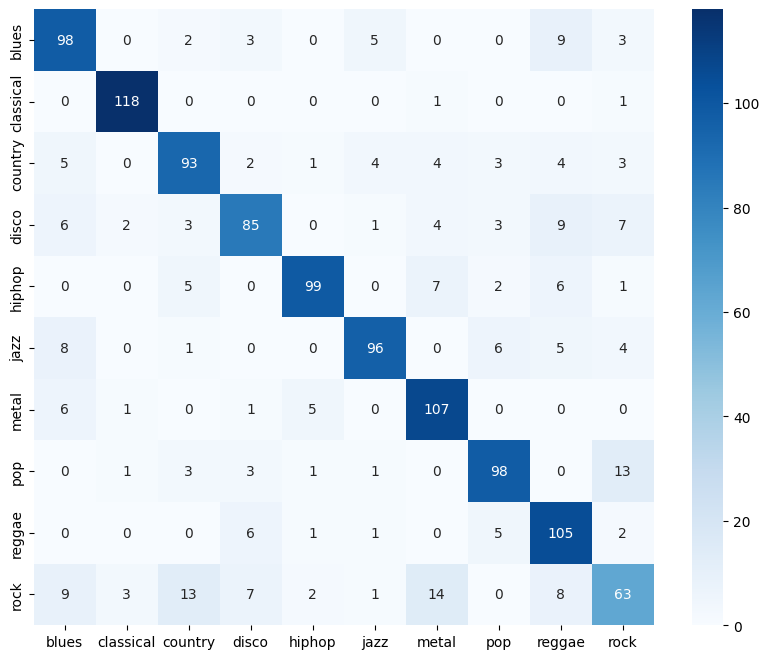

In [10]:
if __name__ == '__main__':
    set_seed(42) # Ensures reproducible results
    
    # 1. LOAD DATA
    # Load images where folder names = class labels
    full_train_dataset = datasets.ImageFolder(root=train_data_dir, transform=data_transforms)
    test_dataset = datasets.ImageFolder(root=test_data_dir, transform=data_transforms)

    # Create a validation split (e.g. 80% train / 20% val)
    val_size = int(VAL_SPLIT_RATIO * len(full_train_dataset))
    train_size = len(full_train_dataset) - val_size
    train_dataset, validation_dataset = random_split(full_train_dataset, [train_size, val_size])

    # Data loaders handle batching and shuffling
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    class_names = full_train_dataset.classes
    print(f"Dataset Training: {len(train_dataset)} | Validation: {len(validation_dataset)} | Test: {len(test_dataset)}")

    # 2. INITIALIZATION
    # Initialize the pre-trained ResNet18 model
    model = get_resnet_model(NUM_CLASSES, DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # 3. TRAINING LOOP
    print("\n--- START TRAINING RESNET18 ---")

    for epoch in range(NUM_EPOCHS):
        model.train() # Enable training mode (gradients, dropout, etc.)
        epoch_loss = 0.0

        for data, targets in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS}"):
            data, targets = data.to(DEVICE), targets.to(DEVICE)

            # Forward pass and loss calculation
            scores = model(data)
            loss = criterion(scores, targets)

            # Backpropagation and weight update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * data.size(0)

        total_train_loss = epoch_loss / len(train_dataset)
        
        # Check accuracy on validation set
        val_acc = validate_epoch(model, validation_loader, DEVICE)

        print(f"Loss: {total_train_loss:.4f} | Val Acc: {val_acc:.4f}")

    # 4. FINAL EVALUATION
    # Test on completely unseen data
    test_model(model, test_loader, DEVICE, class_names)